100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


┌ Warning: `DataFrame(columns::AbstractMatrix)` is deprecated, use `DataFrame(columns, :auto)` instead.
│   caller = #generate#1(::Int64, ::Function, ::Main.Ntl.Models.Mixture{Main.Ntl.Models.NtlParameters{Main.Ntl.Models.GeometricArrivals},Main.Ntl.Models.GaussianParameters}) at synthetic.jl:231
└ @ Main.Ntl.Generate /Users/seanla/Projects/ntl-stick-breaking-julia/src/synthetic.jl:231
┌ Warning: `DataFrame(columns::AbstractMatrix)` is deprecated, use `DataFrame(columns, :auto)` instead.
│   caller = #generate#1(::Int64, ::Function, ::Main.Ntl.Models.Mixture{Main.Ntl.Models.NtlParameters{Main.Ntl.Models.GeometricArrivals},Main.Ntl.Models.GaussianParameters}) at synthetic.jl:233
└ @ Main.Ntl.Generate /Users/seanla/Projects/ntl-stick-breaking-julia/src/synthetic.jl:233


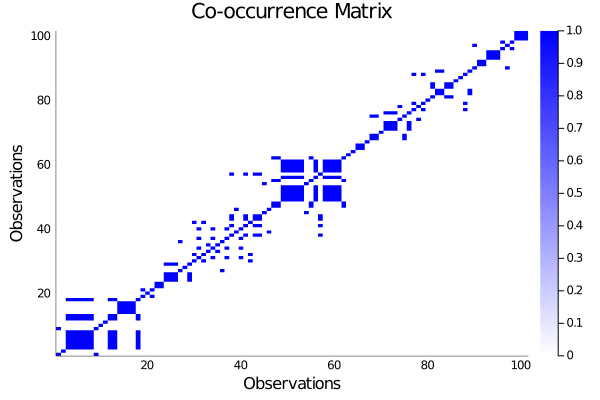

In [4]:
include("../ntl.jl")
import Random

using LinearAlgebra
Random.seed!(1)

data_covariance = Matrix{Float64}(0.1I, 2, 2)
prior_covariance = Matrix{Float64}(I, 2, 2)
prior_mean = Vector{Float64}(zeros(2))
data_parameters = Ntl.Models.GaussianParameters(data_covariance, prior_mean, prior_covariance)

psi_prior = Vector{Float64}([1, 1])
phi_prior = Vector{Float64}([1, 1])
geometric_arrival = Ntl.Models.GeometricArrivals(phi_prior)
ntl_cluster_parameters = Ntl.Models.NtlParameters(psi_prior, geometric_arrival)

mixture_model = Ntl.Models.Mixture(ntl_cluster_parameters, data_parameters)
n = 200
mixture = Ntl.Generate.generate(mixture_model, n=n+1)
data = Matrix(transpose(mixture[:, 2:end]))
training_data = data[:, 1:n]
test_datum = vec(data[:, n+1])
true_clustering = mixture[:, 1]
Ntl.Plot.plot_assignments(true_clustering)
Ntl.Plot.plot_co_occurrence_matrix(true_clustering)

In [2]:
num_clusters = Ntl.Utils.mean_num_clusters(true_clustering)
println("Number of clusters: $num_clusters")

Number of clusters: 39.0


100.0%┣███████████████████████████████████████┫ 999/999 [00:36<00:00, 27.8 it/s]
100.0%┣███████████████████████████████████┫ 1000/1000 [00:01<00:00, 1839.9 it/s]


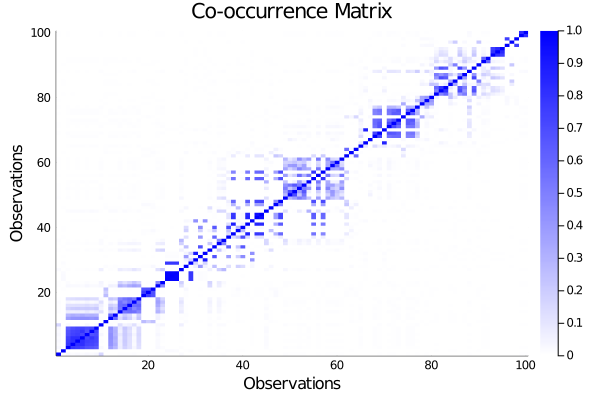

In [2]:
geometric_arrival = Ntl.Models.GeometricArrivals(phi_prior)
ntl_cluster_parameters = Ntl.Models.NtlParameters(psi_prior, geometric_arrival)
gibbs_sampler = Ntl.Samplers.GibbsSampler(num_iterations=1000)
(instances, log_likelihoods) = Ntl.Fitter.fit(training_data, mixture_model, gibbs_sampler)
Ntl.Plot.plot_co_occurrence_matrix(instances)

100.0%┣████████████████████████████████████┫ 1999/1999 [00:13<00:00, 149.5 it/s]
100.0%┣███████████████████████████████████┫ 1000/1000 [00:01<00:00, 1838.3 it/s]


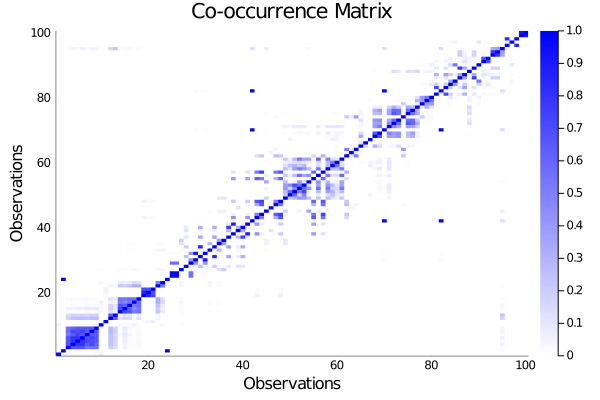

In [3]:
metropolis_hastings_sampler = Ntl.Samplers.MetropolisHastingsSampler(num_iterations=1000, num_burn_in=1000, cluster_radius=5, observation_window=100)
(metropolis_hastings_instances, log_likelihoods) = Ntl.Fitter.fit(training_data, mixture_model, metropolis_hastings_sampler) 
Ntl.Plot.plot_co_occurrence_matrix(metropolis_hastings_instances)

In [4]:
Ntl.Evaluate.evaluate(test_datum, instances, training_data, mixture_model)

-0.8503000835580822

In [5]:
gibbs_num_clusters = Ntl.Utils.mean_num_clusters(instances)
println("Number of clusters: $gibbs_num_clusters")

Number of clusters: 43.21


100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


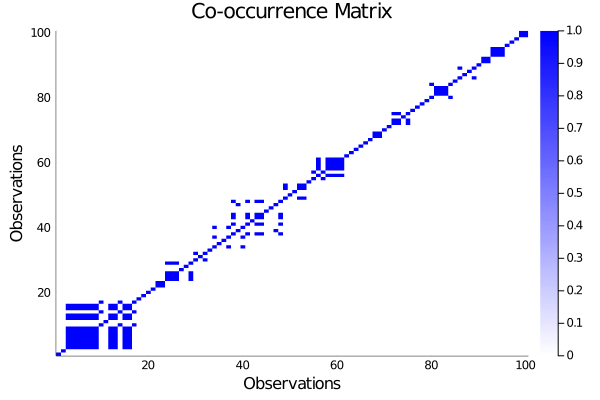

In [6]:
map_estimate = Ntl.Utils.maximum_a_posterior(instances, log_likelihoods)
Ntl.Plot.plot_co_occurrence_matrix(map_estimate)


In [7]:
map_num_clusters = length(unique(map_estimate))
println("MAP Estimate number of clusters: $map_num_clusters")

MAP Estimate number of clusters: 58


100.0%┣███████████████████████████████████┫ 1000/1000 [00:01<00:00, 1833.0 it/s]


┌ Warning: RCall.jl: Loading required package: lpSolve
└ @ RCall /Users/seanla/.julia/packages/RCall/eRsxl/src/io.jl:160


100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


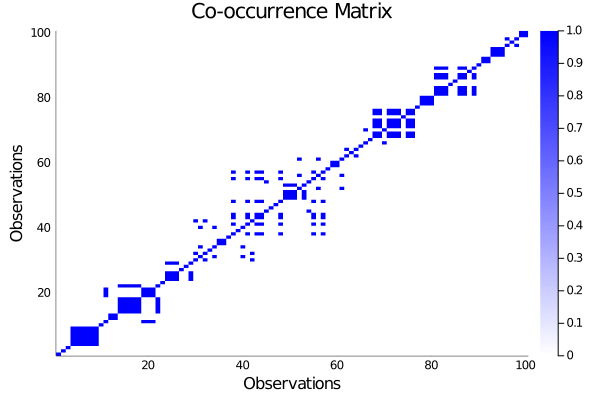

In [8]:
psm = Ntl.Utils.compute_co_occurrence_matrix(instances)
binder_estimate = Ntl.Utils.minbinder(psm, instances)
Ntl.Plot.plot_co_occurrence_matrix(binder_estimate)

100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


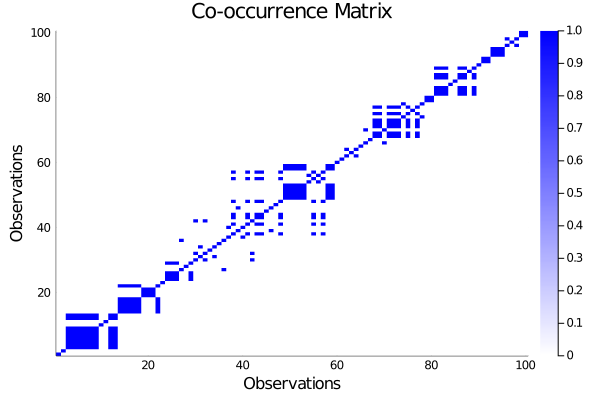

In [9]:
vi_estimate = Ntl.Utils.minVI(psm, instances)
Ntl.Plot.plot_co_occurrence_matrix(vi_estimate)

100.0%┣████████████████████████████████████┫ 1000/1000 [00:03<00:00, 387.8 it/s]
100.0%┣███████████████████████████████████┫ 1000/1000 [00:00<00:00, 2166.3 it/s]


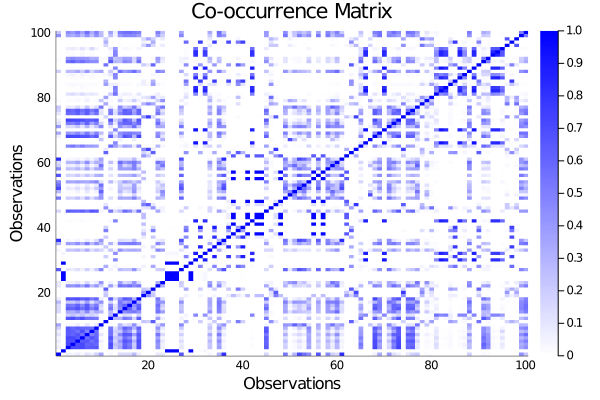

In [10]:
dp_cluster_parameters = Ntl.Models.DpParameters(1)
dp_mixture = Ntl.Models.Mixture(dp_cluster_parameters, data_parameters)
gibbs_sampler = Ntl.Samplers.GibbsSampler(num_iterations=1000)
markov_chain, log_likelihoods = Ntl.Fitter.fit(training_data, dp_mixture, gibbs_sampler)
Ntl.Plot.plot_co_occurrence_matrix(markov_chain)

In [11]:
Ntl.Evaluate.evaluate(test_datum, markov_chain, training_data, dp_mixture)

-1.149045628829536

100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


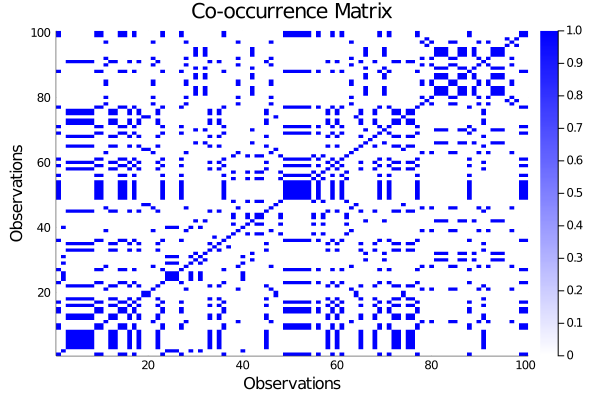

In [12]:
dp_map_estimate = Ntl.Utils.maximum_a_posterior(markov_chain, log_likelihoods)
Ntl.Plot.plot_co_occurrence_matrix(dp_map_estimate)

100.0%┣███████████████████████████████████┫ 1000/1000 [00:00<00:00, 1998.1 it/s]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


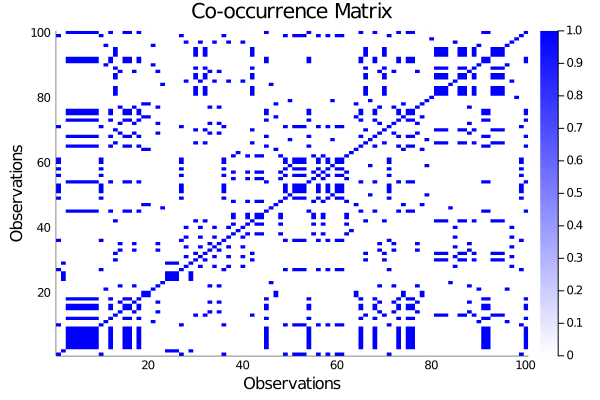

In [13]:
dp_psm = Ntl.Utils.compute_co_occurrence_matrix(markov_chain)
dp_binder_estimate = Ntl.Utils.minbinder(dp_psm, markov_chain)
Ntl.Plot.plot_co_occurrence_matrix(dp_binder_estimate)

100.0%┣██████████████████████████████████████████┫ 1/1 [00:00<Inf:Inf, 0.0 it/s]


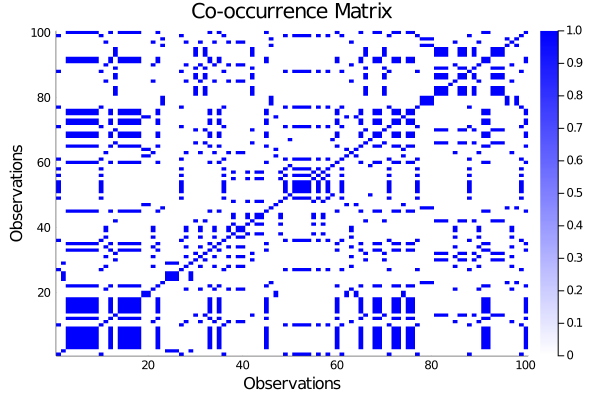

In [14]:
dp_vi_estimate = Ntl.Utils.minVI(dp_psm, markov_chain)
Ntl.Plot.plot_co_occurrence_matrix(dp_vi_estimate)